In [1]:
import pypsa
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import yaml
import os

with open('../../pypsa-earth/config.SEA_base.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
country_longname = {
    "MM": "Myanmar",
    "TH": "Thailand",
    "MY": "Malaysia",
    "LA": "Laos",
    "SG": "Singapore",
    "KH": "Cambodia",
    "VN": "Vietnam",
    "BN": "Brunei",
    "PH": "Philippines",
    "ID": "Indonesia",
    "Peninsular/MY": "Malaysia",
    "Sumatra/ID": "Indonesia",
    "Java-Bali/ID": "Indonesia",
    "Sarawak/MY":  "Malaysia",
    "Kalimantan/ID": "Indonesia",
    "Sabah/MY": "Malaysia",
    "Nusa-Tenggara/ID": "Indonesia",
    "Sulawesi/ID": "Indonesia",
    "Maluku/ID": "Indonesia",
    "Papua/ID": "Indonesia"
    }

country_prefered_order = ['Myanmar', 'Thailand', 'Malaysia','Singapore', 'Laos', 'Cambodia', 'Vietnam', 'Indonesia', 'Brunei', 'Philippines']


preferred_order = pd.Index(
    [
        "transmission lines",
        "hydroelectricity",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "onshore wind",
        "offshore wind",
        "solar PV",
        "solar thermal",
        "OCGT",
        "hydrogen storage",
        "battery storage",
    ]
)

def add_and_rename_countries(df):
    for i in list(country_longname.keys() - set(df.index)):
        df.loc[i] = pd.Series().fillna(0)

    # convert abbreviation into nice long names
    df["Countries"] = [country_longname[c] for c in df.index]
    df = df.set_index("Countries")

    return df

def rename_techs(label):
    if "H2" in label:
        label = "hydrogen storage"
    elif label == "solar":
        label = "solar PV"
    elif label == "offwind-ac":
        label = "offshore wind"
    elif label == "offwind-dc":
        label = "offshore wind"
    elif label == "onwind":
        label = "onshore wind"
    elif label == "ror":
        label = "hydroelectricity"
    elif label == "hydro":
        label = "hydroelectricity"
    elif label == "PHS":
        label = "hydroelectricity"
    elif "battery" in label:
        label = "battery storage"
    elif label == "coal":
        label = "coal"
    elif label == "coal-CFB":
        label = "coal"
    elif label == "coal-SC":
        label = "coal"
    elif label == "coal-USC":
        label = "coal"
    elif label == "coal-SubC":
        label = "coal"
    elif label == "lignite":
        label = "coal"

    return label

In [19]:
color_RE90 = {
            'nuclear': '#ff9000',
            'biomass': '#0c6013',
            'onwind': '#235ebc',
            'solar PV': '#f9d002',
            'geothermal': '#ba91b1',
            'hydroelectricity': "#08ad97",
            'Natural Gas (CCS)': '#d35050',
            'Natural Gas': "#b20101",
            'coal': "#707070"
            }

def add_RE90_legend():
    fig, ax = plt.subplots(figsize=(0, 0))
    ax.axis('off')
    
    pypsa.plot.add_legend_patches(ax=ax, colors = pd.DataFrame(color_RE90.items())[1], labels = pd.DataFrame(color_RE90.items())[0],
                                 legend_kw = {'loc':"upper center",'bbox_to_anchor':(0.5, -0.15), 'frameon':False, 'ncol':5, 'title':"Components", 
                                              'title_fontproperties':{'weight':'bold'}})

    plt.savefig(f'../Figures/RE90_legend.svg',bbox_inches='tight')

def energy_distribution(infn_energy, scenario_PyPSA, dec_name):
    fig, (ax) = plt.subplots(figsize=(8, 2.5))
    df_all = pd.DataFrame()
    
    df_all = pd.DataFrame()
    loads_df_all = pd.DataFrame()
    
    for country in countries:
        energy_df = pd.read_csv(infn_energy[country], index_col=list(range(2)), header=[1, 2, 3])
    
        energy_df.columns = [country]
    
        df = energy_df.groupby(energy_df.index.get_level_values(1)).sum()
    
        loads_df = - energy_df.groupby(energy_df.index.get_level_values(0)).sum().query("index == 'loads'")/ 1e6
    
        # If there is any unique carrier to remove
        if "B2B" in df.index:
            df = df.drop("B2B")
    
        # convert MWh to TWh
        df = df / 1e6
    
        df = df.groupby(df.index.map(rename_techs)).sum()
    
        if df_all.empty:
            df_all = df
        else:
            df_all = pd.concat([df_all,df],axis=1)
    
        if loads_df.empty:
            loads_df_all = loads_df
        else:
            loads_df_all = pd.concat([loads_df_all,loads_df],axis=1)

    new_index_energy = df_all.index.intersection(preferred_order).append(
        df.index.difference(preferred_order)
    )
    
    df_all = add_and_rename_countries(df_all.T).groupby(level=0).sum().T
    
    new_columns = [c for c in country_prefered_order if c in df_all.columns]
    
    df_all.loc[new_index_energy, new_columns].T.plot(
        kind="bar",
        width = 0.9,
        ax=ax,
        stacked=True,
        color=[config["plotting"]["tech_colors"][i] for i in new_index_energy],
        rot=90,
        legend=False
    )
    
    loads_df_all = add_and_rename_countries(loads_df_all.T).groupby(level=0).sum().T
    
    loads_df_all.loc[:, new_columns].T.plot(
        kind="bar",
        ax=ax,
        width = 0.9,
        edgecolor="black",
        linestyle = 'dashed',
        fill=False,
        rot=90,
        legend=False
    )
    
    ax.set_ylim([-200, 2500])
    ax.grid(axis="y")
    ax.set_xlabel("")
    ax.set_ylabel("TWh/a")
    
    #df_color = pd.DataFrame(data = {"color" : [n.carriers.loc[c,"color"] for c in n.generators.carrier.unique()]}, index = n.generators.carrier.unique())
    
    #df_color = df_color.groupby(df_color.index.map(rename_techs)).sum()
    
    #for i in ["hydrogen storage","battery storage"]:
    #    df_color.loc[i,"color"] = config["plotting"]["tech_colors"][i] 
    
    #df_color.index.intersection(preferred_order).append(df_color.index.difference(preferred_order))
    
    #df_color = df_color.drop(["coal","coal-CFB","coal-SC","coal-SubC","coal-USC","lignite","oil"])
    
    #pypsa.plot.add_legend_patches(ax=ax, colors = df_color.color, labels = df_color.index,
    #                             legend_kw = {'loc':"lower center",'bbox_to_anchor':(0.5, 1), 'frameon':False, 'ncol':4, 'title':"Energy Sources", 
    #                                          'title_fontproperties':{'weight':'bold'}})

    ax.annotate('Regional\nLoad/a',
        xy=(3, loads_df_all["Singapore"]),  # theta, radius
        xytext=(3, loads_df_all["Singapore"]+750),    # fraction, fraction
        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth = 5),
        horizontalalignment='center',
        verticalalignment='top',
        )

    ax.set_xticklabels([])

    ax.set_title(f'{scenario_PyPSA}{dec_name}_2050', 
                 loc='left', 
                 x=0.02, 
                 y=0.85,
                 fontsize=9
                )

    if not os.path.exists(f'../Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'../Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'../Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_energy_distribution_validation.svg',bbox_inches='tight')

In [11]:
scenarios = ["SEA_IRENA_"]
folder_name = "pypsa-earth"
network_names = {"BAU":"elec_s_200_ec_lcopt_3H",
                 "SE":"elec_s_200_ec_lcopt_Co2L0.500924-3H",
                 "DEC":"elec_s_200_ec_lcopt_Co2L0.050092-3H"}
dec_name = "DEC"

year = 2050

fn = {dec_name:pypsa.Network(f"../../{folder_name}/results/{scenario}{year}/networks/{network_names[dec_name]}.nc") for dec_name in network_names.keys()}


INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


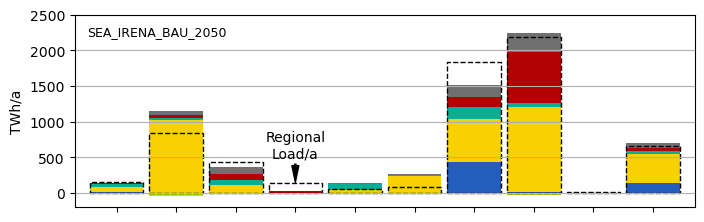

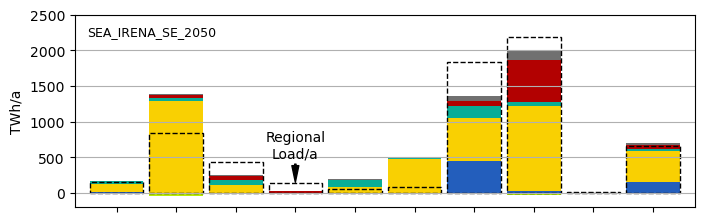

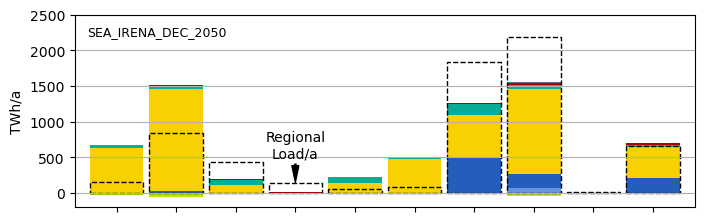

In [20]:
for dec_name in network_names.keys():
    n = fn[dec_name]
    countries = n.buses.country.unique()
    infn_energy = {country:f"../../{folder_name}/results/{scenario + str(year)}/summaries/{network_names[dec_name]}_{country}/energy.csv" for country in countries}
    energy_distribution(infn_energy, scenario, dec_name)

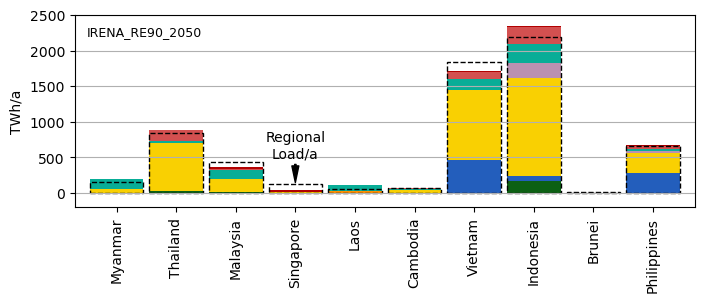

In [21]:
def rename_techs_IRENA(label):
    if label == "Biomass":
        label = "biomass"
    elif label == "ccs":
        label = "OCGT"
    elif label == "Geothermal":
        label = "geothermal"
    elif label == "Hydropower":
        label = "hydroelectricity"
    elif label == "Natural Gas":
        label = "CCGT"
    elif label == "Wind":
        label = "onwind"
    elif label == "Nuclear ":
        label = "nuclear"

    return label

country_longname_IRENA = {
    "MM": "Myanmar",
    "TH": "Thailand",
    "MY": "Malaysia",
    "LA": "Laos",
    "SG": "Singapore",
    "KH": "Cambodia",
    "VN": "Vietnam",
    "BN": "Brunei",
    "PH": "Philippines",
    "ID": "Indonesia"}

def add_and_rename_countries(df):
    for i in list(country_longname_IRENA.keys() - set(df.index)):
        df.loc[i] = pd.Series().fillna(0)

    # convert abbreviation into nice long names
    df["Countries"] = [country_longname_IRENA[c] for c in df.index]
    df = df.set_index("Countries")

    return df

countries = ["BN", "KH", "ID", "LA", "MY", "MM", "PH", "SG", "TH", "VN"]

df_all = pd.DataFrame()
fig, (ax) = plt.subplots(figsize=(8, 2.5))

for country in countries:
    d = pd.read_excel("../Tables/IRENA-Power-BI/IRENA-Power-BI-Power-Generation.xlsx",sheet_name=country, index_col=0).loc["2050, 3. 1.5-S 90% RE",:]
    df = pd.DataFrame({country:d})

    #display(df)

    if df_all.empty:
        df_all = df
    else:
        df_all = pd.concat([df_all,df], axis = 1)

df_all = df_all.dropna(how='all')
df_all = df_all.groupby(df_all.index.map(rename_techs_IRENA)).sum()
re_share = df_all.loc["RE Share Generation",:]
df_all = df_all.drop(index=['RE Share Generation'])

df_all = add_and_rename_countries(df_all.T).T



new_index_energy =  ['nuclear','biomass','onwind', 'solar PV', 'geothermal', 'hydroelectricity', 'OCGT', 'CCGT']
#new_index_energy = df_all.index.intersection(preferred_order).append(
#    df_all.index.difference(preferred_order)
#)

new_columns = [c for c in country_prefered_order if c in df_all.columns]

df_all.loc[new_index_energy, new_columns].T.plot(
    kind="bar",
    width = 0.9,
    ax=ax,
    stacked=True,
    color=[config["plotting"]["tech_colors"][i] for i in new_index_energy],
    rot=90,
    legend=False
)

df_IRENA = pd.read_excel(r"../Tables/IRENA-Power-BI/IRENA-Power-BI-Export-Import.xlsx","Power Flow")

df_IRENA = df_IRENA.set_index("Country")
df_IRENA["IRENA_elec_demand"] = df_IRENA["Generation"] + df_IRENA["Net Export (-)/lmport (+)"]
df_IRENA = df_IRENA.drop(columns={"Generation","Net Export (-)/lmport (+)"})

df_IRENA

loads_df_all = add_and_rename_countries(df_IRENA).groupby(level=0).sum().T
    
loads_df_all.loc[:, new_columns].T.plot(
    kind="bar",
    ax=ax,
    width = 0.9,
    edgecolor="black",
    linestyle = 'dashed',
    fill=False,
    rot=90,
    legend=False
)

ax.set_ylim([-200, 2500])
ax.grid(axis="y")
ax.set_xlabel("")
ax.set_ylabel("TWh/a")

ax.annotate('Regional\nLoad/a',
    xy=(3, loads_df_all["Singapore"]),  # theta, radius
    xytext=(3, loads_df_all["Singapore"]+750),    # fraction, fraction
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth = 5),
    horizontalalignment='center',
    verticalalignment='top',
    )

scenario_PyPSA = "IRENA_"
dec_name = "RE90"

ax.set_title(f'{scenario_PyPSA}{dec_name}_2050', 
             loc='left', 
             x=0.02, 
             y=0.85,
             fontsize=9
            )

if not os.path.exists(f'../Figures/{scenario_PyPSA}{dec_name}'):
    os.mkdir(f'../Figures/{scenario_PyPSA}{dec_name}')

plt.savefig(f'../Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_energy_distribution_validation.svg',bbox_inches='tight')

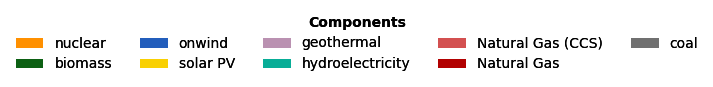

In [203]:
add_RE90_legend()

In [172]:
n = fn["BAU"]
n.carriers

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
biomass,0.0000,#0c6013,Biomass,inf,0.0
coal-USC,0.3361,#505050,Coal-Usc,inf,0.0
coal-SC,0.3361,#606060,Coal-Sc,inf,0.0
coal,0.3361,#707070,Coal,inf,0.0
nuclear,0.0000,#ff9000,Nuclear,inf,0.0
coal-SubC,0.3361,#909090,Coal-Subc,inf,0.0
lignite,0.4069,#9e5a01,Lignite,inf,0.0
coal-CFB,0.3361,#808080,Coal-Cfb,inf,0.0
OCGT,0.1980,#d35050,Open-Cycle Gas,inf,0.0
